In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import plotly
import pandas as pd
import mpnum as mp
import sklearn
import plotly.offline as ply
from sklearn import svm
from numba import autojit

<IPython.core.display.Javascript object>


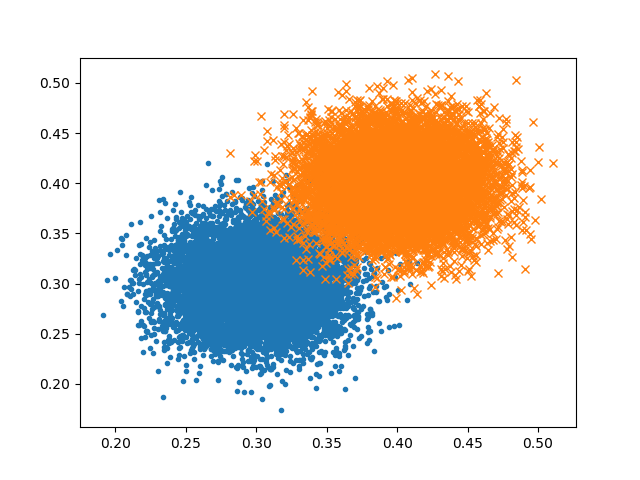

In [3]:
%matplotlib notebook
#Generiamo il toy model.. Sampling da due gaussiane 2d overlappate
mean1=[0.3,0.3]
cov1=[[0.001,0],[0,0.001]]
mean2=[0.4,0.4]
cov2=[[0.001,0],[0,0.001]]
data1=np.random.multivariate_normal(mean1, cov1, 10000)
data2=np.random.multivariate_normal(mean2, cov2, 10000)
data1_x=data1.T[0]
data1_y=data1.T[1]
data2_x=data2.T[0]
data2_y=data2.T[1]
f1=plt.figure()
plt.plot(data1_x,data1_y,".")
plt.plot(data2_x,data2_y,"x")
plt.show()

label1=np.array([0]*len(data1))
label2=np.array([1]*len(data2))
label=np.concatenate([label1,label2])
data=np.concatenate([data1,data2])


Classical support vector machine for classification

In [4]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function(np.c_[xi.ravel(), yj.ravel()])
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

In [5]:

#Assumed you have, X (predictor) and Y (target) for training data set and x_test(predictor) of test_dataset
# Create SVM classification object 
model = svm.SVC(kernel='linear', C=4, gamma=1) 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(data, label)
model.score(data, label)
#Predict Output
data3=np.random.multivariate_normal(mean1, cov1, 100000)
data4=np.random.multivariate_normal(mean2, cov2, 100000)
predicted=model.predict(data3)

<IPython.core.display.Javascript object>


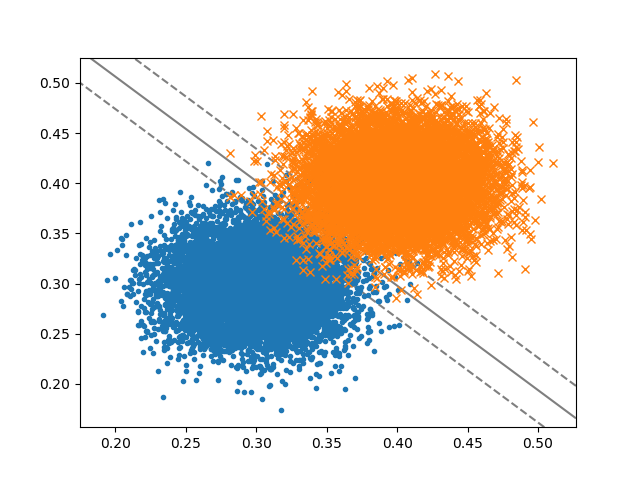

In [6]:
plt.plot(data1_x,data1_y,".",label="gaus1")
plt.plot(data2_x,data2_y,"x",label="gaus2")
plot_svc_decision_function(model)
plt.show()

In [7]:
np.sum(predicted)

1297

## Iniziamo con Tensor Networks

Prepariamo i dati

In [13]:
@autojit
def feature_map(x):
    return(np.array([np.cos(x*np.pi/2.),np.sin(x*np.pi/2.)]))
@autojit
def delta(x,y):
    if(x == y ):
        delta=1
    else:
        delta=0
    return delta

def train(data,label,weight,l):
    kdelta=0
    j=l
    for i in range(0,len(data)):
        coeff_temp=0
        kdelta=delta(label[i],j)
        #print(label[i])
        x_mpa = mp.MPArray.from_array(feature_map(data[i][0]), plegs=1)
        y_mpa = mp.MPArray.from_array(feature_map(data[i][1]), plegs=1)
        f=mp.dot(weight,y_mpa)
        f=mp.dot(f,x_mpa)
        coeff_temp=(kdelta-f.to_array())
        big_data= mp.MPArray.from_kron([feature_map(data[i][0]),feature_map(data[i][1])])
        big_data=big_data.group_sites(2)
        
        if i is 0:
            temp=coeff_temp*big_data
        else:
            temp=temp+(coeff_temp*big_data)
    return temp
@autojit
def decide(w_class0,w_class1,x,y):
    x_mpa = mp.MPArray.from_array(feature_map(x), plegs=1)
    y_mpa = mp.MPArray.from_array(feature_map(y), plegs=1)
    valuef0=mp.dot(w_class0,y_mpa)
    valuef0=mp.dot(valuef0,x_mpa)
    valuef1=mp.dot(w_class1,y_mpa)
    valuef1=mp.dot(valuef1,x_mpa)
    if(np.fabs(valuef0.to_array())>np.fabs(valuef1.to_array())):
        return 0
    else:
        return 1

In [14]:
#Cosi si creano gli array dei dati
mps = mp.MPArray.from_kron([feature_map(data3[0][0]), feature_map(data3[0][1])])
mps.to_array()

array([[ 0.7449723 ,  0.42005255],
       [ 0.4514242 ,  0.25453548]])

In [15]:
#Creo un MPS con  l 
#                 |
#               (   )-(  )
#                 |    |
#           phi(x)   phi(y)

rng = np.random.RandomState(seed=43)
mpa = mp.random_mpa(sites=2, ldim=[[1,2],[2]], bdim=2, randstate=rng, normalized=True)

In [16]:
mpa2=mpa.group_sites(2)
mpa2.plegs

(3,)

In [21]:
learned0=train(np.concatenate([data1[0:10000],data2[0:10000]]),np.concatenate([label1[0:10000],label2[0:10000]]),mpa2,0)[0]
learned1=train(np.concatenate([data1[0:10000],data2[0:10000]]),np.concatenate([label1[0:10000],label2[0:10000]]),mpa2,1)[0]

In [22]:
classifydata3=[]
classifydata4=[]
for i in range(0,len(data3)):
    classifydata3.append(decide(learned0,learned1,data3[i][0],data3[i][1]))
    classifydata4.append(decide(learned0,learned1,data4[i][0],data4[i][1]))
classifydata3=np.array(classifydata3)
classifydata4=np.array(classifydata4)

In [27]:
def plot_tn_decision_function(wclass0,wclass1, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] =2*( decide(wclass0,wclass1,xi,yj)-0.5)
    # plot the margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

<IPython.core.display.Javascript object>


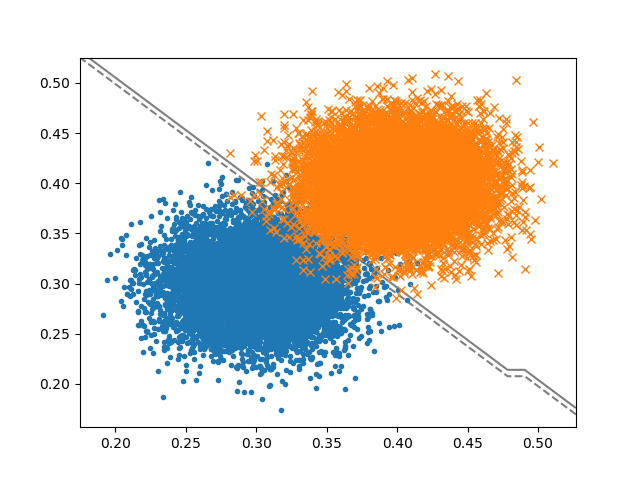

In [28]:
plt.plot(data1_x,data1_y,".",label="gaus1")
plt.plot(data2_x,data2_y,"x",label="gaus2")
plot_tn_decision_function(learned0,learned1, ax=None)
plt.show()